In [2]:
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_tavily import TavilySearch
from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
from langgraph.types import interrupt, Command
from typing import TypedDict, Annotated, Literal, Optional, Dict
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

In [3]:
# initializing the models
load_dotenv()
model = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)

evaluator = ChatGroq(
    model=os.getenv("evaluater_model"),
    api_key=os.getenv("api_key")
)

embedding_model = OllamaEmbeddings(model="llama3.2")

In [4]:
loader = PyPDFLoader(file_path="Attention.pdf")
docs = loader.load()
print(len(docs))

11


In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 200, chunk_overlap = 80)
chunks = text_splitter.split_documents(docs)

print(len(chunks))

234


In [6]:
vector_store = Chroma.from_documents(
    embedding=embedding_model,
    documents=chunks,
    collection_name= "my_collection"
)

In [7]:
# here I am using mmr so that each chunk retrieved covers different angles
retrievers = vector_store.as_retriever(search_type = "mmr", search_kwargs = {'k' : 2, 'fech_k' : 5, 'lambda_mult' : 0.7})


In [8]:
class Format(BaseModel):
    output :list[str]

class summary(BaseModel):
    summary : str

class Evaluation(BaseModel):
    evaluation : float = Field(ge=0, le=1, description="this containt the value got for the answer providd to the llm after evaluation.")
    feedback : str = Field(description = "this should containt the place where the refining should be done, it is like feedback to imporive the evaluation")

op_format = PydanticOutputParser(pydantic_object=Format)
summary_format = PydanticOutputParser(pydantic_object=summary)
evaluation_format = PydanticOutputParser(pydantic_object=Evaluation)

In [9]:
class RAG_state(TypedDict):
    latest_question : Annotated[list[HumanMessage], add_messages]
    sub_questions : Annotated[list[str], add_messages]
    answers : Annotated[list[str], add_messages]
    final_answer : str
    retry_count : int
    evaluation : float = Field(ge=0, le=1)
    feedback : str
    clarification : str


In [10]:
# I need sqlite db to store the checkpoints to make my agent remember the past topics
conn = sqlite3.connect(database='RAG.db', check_same_thread=False)
# this creates the checkpointer that saves the checkpoint in the database and allows persistance
checkpointer = SqliteSaver(conn=conn)

### Query Decomposer:
- Query decomposer is used to avoid getting only the content that matches to the question and focusing on getting all the context from the document from all angles. 

 for example:

 If the question is **Why shouldn't we smoke?**, then the decomposed questions can be
 * Why somking is bad?
 * Somking effect on our health
 * How does it effect our body?

are the questions that can hit different angle, which produces the quality answers

In [58]:
# all node's task
def query_decomposition(state : RAG_state):
    # first when we get the prompt, first we decompose the main question so that we can make multiple diferent questions in the same sense to extract the relevant contnet from the RAG
    template = PromptTemplate(template="""You are a query decomposition agent.
    Your task is to transform a single high-level user question into 2–3 concise, non-overlapping sub-questions optimized for semantic search and retrieval.
    Rules:
    - Each sub-question must target a distinct angle of the original question.
    - Sub-questions must be factual, concrete, and searchable.
    - Avoid rephrasing the same question multiple times.
    - Do NOT answer the questions.
    - Do NOT add explanations.
    - Keep each sub-question under 15 words only.
    - if the question is simple then make the sub-questions simple too.
    - Prefer "what / how / why" formulations when useful.
    Question: 
    {question}
    Output format:
    {fm}""", input_variables=['question'],partial_variables={'fm' : op_format.get_format_instructions()})
    chain = template | model | op_format
    output = chain.invoke({"question" : state['latest_question']}).output
    return {'sub_question' : [output]}

In [59]:
# retreiving the relevant content from the docs
def retriever(state : RAG_state):
    answers = []
    answer = retrievers.invoke(state['latest_question'])
    answers.append(answer)
    for question in state['sub_questions']:
        answer = retrievers.invoke(question)
        answers.append(answer)
    page_content = []
    for ans in answers:
        element = []
        for i in ans:
            element.append(i.page_content)
        page_content.append(element)
    
    return {'answers' : page_content}

In [60]:
# summarize the answers that we got from each sub-questions in such a way that it provides a different angle for summarizing for each list of sub-question
def summarizer(state : RAG_state):
    answers = state['answers']
    question = state['latest_question']
    sub_quesitons = state['sub_questions']
    ques_ans_dict : dict[str, list[str]] = {}
    ques_ans_dict[question] = answers[0]
    for index, answer in enumerate(answers):
        if index == 0:
            continue
        ques_ans_dict[sub_quesitons[index-1]] = answer
    template = PromptTemplate(template="""You are a summarization agent.
    Task:
    - Summarize the retrieved chunks for each sub-question.
    - Each sub-question maps to a list of concise summary sentences.
    - Summaries may mix information from multiple chunks, but must reflect the original content accurately.
    - Do not hallucinate; use only the content from the chunks.
    - Do not dilute important details.       
    - If there is no context in the answer list based on the question then just say "No context match". 
                                                                                                              
    Input:
    - questions_and_chunks: a JSON object where each key is a sub-question, and each value is a list of strings (chunks retrieved for that sub-question).\n
    {ques_ans_dict}
                                                
    Output format:
    The output should only contain the answer(no question with it)
    {format_ins}
                        
    Rules:
    - No explanations outside JSON.
    - Preserve the list of strings per sub-question.
    - If a sub-question has no content, return ["Not found in the provided context"].
    """, input_variables = ['ques_ans_dict'], partial_variables={'format_ins' : summary_format.get_format_instructions()})

    chain = template | model | summary_format
    result = chain.invoke({"ques_ans_dict" : ques_ans_dict}).summary
    return {'final_answer' : result}

In [61]:
# evaluating the asnwer based on the question and sub_questions generated, if the evaluation is > 0.7 then pass and if still better can be done then retry after refining the query and clarification
def evaluation(state : RAG_state):
    latest_question = state['latest_question']
    questions = state['sub_questions']
    final_answer = state['final_answer']
    prompt = PromptTemplate(template="""You are an evaluation agent.
    Task:
    - Evaluate the quality of the provided answer to the given question.
    - Provide a **score between 0 and 1**, where 1 is perfect and 0 is completely wrong.
    - Provide **feedback** explaining why the score was given and suggestions to improve the answer (e.g., missing information, inaccurate, vague, unclear wording).
    - Be concise but informative in the feedback.
    - Base your evaluation **strictly on the question and the provided answer**. Do not assume extra knowledge.
    - Do NOT include the question in the output, only the score and feedback.

    Input:
    - question: the original user question
    {latest_question} \n
    {sub_questions}
    - answer: the generated answer to evaluate
    {final_answer}                            
    Output format (return only valid JSON):
    {format_ins}                
    """, input_variables=['latest_question', 'sub_questions', 'final_answer'], partial_variables={'format_ins': evaluation_format.get_format_instructions()})
    chain = prompt | evaluator | evaluation_format
    result = chain.invoke({'latest_question' : latest_question, "sub_questions" : questions, "final_answer" : final_answer})
    return {"evaluation" : result.evaluation, "feedback" : result.feedback}

In [63]:
# refining the query
def refining_query(state: RAG_state):
    pass

In [64]:
# retry logic
def retry_logic(state : RAG_state):
    pass

In [65]:
# human clarification for the asnwer and the question
def human_clarification(state : RAG_state):
    pass

In [66]:
state = RAG_state(latest_question = "Why is smoking bad?")
query_decomposition(state)

{'sub_question': [['What health problems are caused by smoking?',
   'How does smoking affect the economy and healthcare costs?',
   'Why does smoking contribute to environmental pollution?']]}

In [67]:
state = RAG_state(latest_question = "Why is smoking bad?", sub_questions=['What health risks are associated with smoking?',
   'How does smoking affect the cardiovascular system?',
   'Why does smoking lead to addiction?'])
retriever(state)

{'answers': [['keeping the amount of computation constant, as described in Section 3.2.2. While single-head\nattention is 0.9 BLEU worse than the best setting, quality also drops off with too many heads.',
   'heads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic\nand semantic structure of the sentences.\n5 Training'],
  ['the maximum path length between any two input and output positions in networks composed of the\ndifferent layer types.',
   'were chosen after experimentation on the development set. We set the maximum output length during\ninference to input length + 50, but terminate early when possible [31].'],
  ['keeping the amount of computation constant, as described in Section 3.2.2. While single-head\nattention is 0.9 BLEU worse than the best setting, quality also drops off with too many heads.',
   'aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate\nself-attention and discuss

In [68]:
state = RAG_state(latest_question = "Why is smoking bad?", 
                  sub_questions=['What health risks are associated with smoking?', 'How does smoking affect the cardiovascular system?','Why does smoking lead to addiction?'], 
                  answers=[['keeping the amount of computation constant, as described in Section 3.2.2. While single-head\nattention is 0.9 BLEU worse than the best setting, quality also drops off with too many heads.',
                            'heads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic\nand semantic structure of the sentences.\n5 Training'],
                            ['the maximum path length between any two input and output positions in networks composed of the\ndifferent layer types.',
                            'were chosen after experimentation on the development set. We set the maximum output length during\ninference to input length + 50, but terminate early when possible [31].'],
                            ['keeping the amount of computation constant, as described in Section 3.2.2. While single-head\nattention is 0.9 BLEU worse than the best setting, quality also drops off with too many heads.',
                            'aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate\nself-attention and discuss its advantages over models such as [14, 15] and [8].\n3 Model Architecture'],
                            ['the input or output sequences [2, 16]. In all but a few cases [22], however, such attention mechanisms\nare used in conjunction with a recurrent network.',
                            'nov. Dropout: a simple way to prevent neural networks from overﬁtting. Journal of Machine\nLearning Research, 15(1):1929–1958, 2014.']])
summarizer(state)

{'final_answer': 'No context match'}

In [69]:
state = RAG_state(latest_question = "Why is smoking bad?", 
                  sub_questions=['What health risks are associated with smoking?', 'How does smoking affect the cardiovascular system?','Why does smoking lead to addiction?'], 
                  final_answer= 'No context match')

evaluation(state)

{'evaluation': 0.0,
 'feedback': 'The answer does not provide any relevant information to address the question. It appears to be unrelated or incomplete, lacking context or explanation about the health risks associated with smoking. To improve, the answer should provide specific details about the negative effects of smoking, such as its impact on cardiovascular health, respiratory system, or addiction.'}

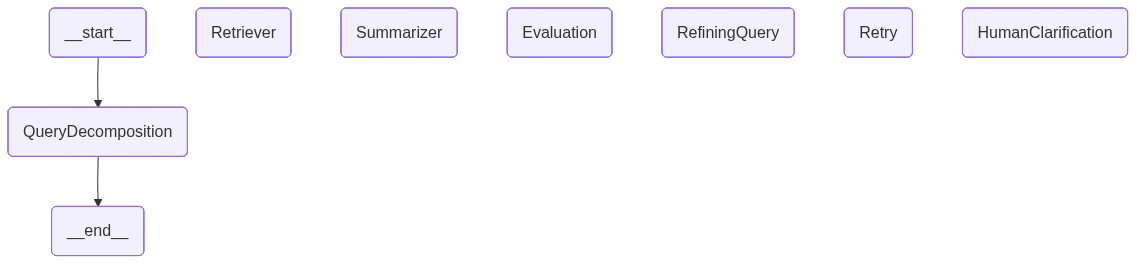

In [73]:
graph = StateGraph(RAG_state)

graph.add_node("QueryDecomposition", query_decomposition)
graph.add_node("Retriever", retriever)
graph.add_node("Summarizer", summarizer)
graph.add_node("Evaluation", evaluation)
graph.add_node("RefiningQuery", refining_query)
graph.add_node("Retry", retry_logic)
graph.add_node("HumanClarification", human_clarification)

graph.add_edge(START, "QueryDecomposition")

workflow = graph.compile()
workflow